# Electricity Demand Forecasting Project | Part 2 - Recurrent Neural Networks

**Import libraries and packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import datetime as dt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import tensorflow as tf

2025-06-17 16:58:26.412034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Relevant helper functions created in _Part 1_ are summarised in a separate notebook and imported below.**

In [2]:
%run Functions.ipynb

## 1. Import, Clean and Explore Data

In [3]:
# Import Electricity Demand Data
data_dict = {}

for data_year in range(2016, 2025):
    data_dict[data_year] = pd.read_csv(f'data/total_load_{data_year}.csv')

data_full = pd.concat(data_dict.values())

data_2025 = pd.read_csv('data/total_load_2025.csv')

In [4]:
data_full = format_data(data_full)

data_2025 = format_data(data_2025)
data_2025.drop(data_2025.loc['2025-05-01':].index, inplace=True)
data_2025['Load'] = data_2025['Load'].astype(float)

In [5]:
# Check length of dataset - result should be 0
len(data_full) - (dt.date(2025, 1, 1) - dt.date(2016, 1, 1)).days * 96

0

In [6]:
data_train = data_full.loc[:'2023-12-31'].copy()
data_valid = data_full.loc['2024-01-01':].copy()

In [7]:
std_load = StandardScaler()

data_train_transformed = pd.DataFrame(std_load.fit_transform(data_train),
                                      columns=data_train.columns,
                                      index=data_train.index)

data_valid_transformed = pd.DataFrame(std_load.transform(data_valid),
                                           columns=data_valid.columns,
                                           index=data_valid.index)

y_train_true = data_train.loc['2016-01-22':, 'Load'].copy()
y_valid_true = data_valid.loc['2024-01-22':, 'Load'].copy()

In [8]:
public_holidays = list(holidays.country_holidays(country='Netherlands', years=range(2015, 2026)).keys())

## 2. Feature Selection

We will use the same features determined in the Part 1:
- Lagging load values corresponding to the same time interval of the prior 3 weeks (21 values).
- Holiday indicator (1 value).

We will create sequential datasets using the `timeseries_dataset_from_array()` functionality. For our holiday indicator, we will need to shift this one day ahead - i.e. "holiday tomorrow", corresponding to the target. Therefore in our data processing step we will append one more day after the end of each period, to capture this in the shift, and then drop that day.

This is included in section 3 below.

## 3. Model Selection and Evaluation

We will prepare the model data, train and evaluate the following RNN models:
- Simple RNN
- Deep RNN
- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

In [9]:
# Helper function to simplify train_test_model function below
def invert_pred(y_true, y_pred, transformer=std_load):
    return pd.Series(transformer.inverse_transform(y_pred.reshape(-1, 1))[:, 0],
                     index=y_true.index)

def mae(y_true, y_pred, invert=True):
    if invert:
        return mean_absolute_error(y_true, invert_pred(y_true, y_pred))
    else:
        return mean_absolute_error(y_true, y_pred)

In [10]:
# Helper function to train and evaluate each model
def train_test_model(model, train_ds, valid_ds, learning_rate, y_train=y_train_true, y_valid=y_valid_true,
                     epochs=50, train_ds_pred=None):
    """
    Trains and evaluates a model (MAE), returning predictions if specified.
    """
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=5, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, metrics=["mae"])
    
    history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs,
                        callbacks=[early_stopping_cb])

    y_valid_pred = model.predict(valid_ds)
    
    if train_ds_pred is not None:
        y_train_pred = model.predict(train_ds_pred)
        return mae(y_train, y_train_pred), mae(y_valid, y_valid_pred)
    else: return mae(y_valid, y_valid_pred)

In [11]:
# Prep model data
X_train = add_weekday_holiday(pd.concat([data_train_transformed, data_valid.loc['2024-01-01']]),
                              public_holidays)
X_valid = add_weekday_holiday(pd.concat([data_valid_transformed, data_2025.loc['2025-01-01']]),
                              public_holidays)

X_train['Holiday_next_day'] = X_train['Holiday'].shift(-96) # 1 day = 96 time intervals
X_train.drop('Holiday', axis=1, inplace=True)

X_valid['Holiday_next_day'] = X_valid['Holiday'].shift(-96) # 1 day = 96 time intervals
X_valid.drop('Holiday', axis=1, inplace=True)

X_train.drop(X_train.loc['2024-01-01'].index, inplace=True)
X_valid.drop(X_valid.loc['2025-01-01'].index, inplace=True)

In [12]:
# Prep model datasets
seq_length = 21 # 3 weeks

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_train.to_numpy(),
    targets=X_train['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96, # daily values
    batch_size=32,
    shuffle=True,
    seed=42)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_valid.to_numpy(),
    targets=X_valid['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96,
    batch_size=32,
    seed=42)

train_ds_pred = tf.keras.utils.timeseries_dataset_from_array(
    X_train.to_numpy(),
    targets=X_train['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96,
    batch_size=32,
    shuffle=False)

In [13]:
simple_rnn = tf.keras.Sequential()
simple_rnn.add(tf.keras.layers.Input(shape=[None, 2]))
simple_rnn.add(tf.keras.layers.SimpleRNN(32))
simple_rnn.add(tf.keras.layers.Dense(1))

simple_rnn_mae_train, simple_rnn_mae_valid = train_test_model(simple_rnn, train_ds, valid_ds, learning_rate=0.02,
                                               train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {simple_rnn_mae_train:.2f}')
print(f'Validation MAE: {simple_rnn_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 0.0398 - mae: 0.1912 - val_loss: 0.0244 - val_mae: 0.1572
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.0324 - mae: 0.1708 - val_loss: 0.0246 - val_mae: 0.1589
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - loss: 0.0309 - mae: 0.1668 - val_loss: 0.0251 - val_mae: 0.1587
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.0299 - mae: 0.1644 - val_loss: 0.0275 - val_mae: 0.1727
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - loss: 0.0292 - mae: 0.1630 - val_loss: 0.0250 - val_mae: 0.1593
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 0.0286 - mae: 0.1620 - val_loss: 0.0249 - val_mae: 0.1594
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step

Training MAE: 349.13
Validation MAE: 332.04


In [14]:
# Deep RNN
deep_rnn = tf.keras.Sequential()
deep_rnn.add(tf.keras.layers.Input(shape=[None, 2]))
deep_rnn.add(tf.keras.layers.SimpleRNN(32, return_sequences=True))
deep_rnn.add(tf.keras.layers.SimpleRNN(32, return_sequences=True))
deep_rnn.add(tf.keras.layers.SimpleRNN(32))
deep_rnn.add(tf.keras.layers.Dense(1))

deep_rnn_mae_train, deep_rnn_mae_valid = train_test_model(deep_rnn, train_ds, valid_ds, learning_rate=0.02,
                                                         train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {deep_rnn_mae_train:.2f}')
print(f'Validation MAE: {deep_rnn_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 114s 13ms/step - loss: 0.0408 - mae: 0.1951 - val_loss: 0.0240 - val_mae: 0.1586
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 139s 12ms/step - loss: 0.0300 - mae: 0.1679 - val_loss: 0.0251 - val_mae: 0.1658
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 120s 14ms/step - loss: 0.0268 - mae: 0.1607 - val_loss: 0.0271 - val_mae: 0.1729
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 136s 13ms/step - loss: 0.0246 - mae: 0.1553 - val_loss: 0.0267 - val_mae: 0.1709
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - loss: 0.0227 - mae: 0.1506 - val_loss: 0.0259 - val_mae: 0.1651
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 116s 13ms/step - loss: 0.0213 - mae: 0.1465 - val_loss: 0.0264 - val_mae: 0.1676
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step

Training MAE: 345.20
Validation MAE: 334.86


In [15]:
# LSTM Model
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Input(shape=[None, 2]))
lstm.add(tf.keras.layers.LSTM(32))
lstm.add(tf.keras.layers.Dense(1))

lstm_mae_train, lstm_mae_valid = train_test_model(lstm, train_ds, valid_ds, learning_rate=0.02,
                                                             train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {lstm_mae_train:.2f}')
print(f'Validation MAE: {lstm_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.1116 - mae: 0.3499 - val_loss: 0.0454 - val_mae: 0.2254
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - loss: 0.0445 - mae: 0.2011 - val_loss: 0.0276 - val_mae: 0.1707
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 138s 9ms/step - loss: 0.0361 - mae: 0.1805 - val_loss: 0.0253 - val_mae: 0.1621
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0337 - mae: 0.1735 - val_loss: 0.0250 - val_mae: 0.1615
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 89s 10ms/step - loss: 0.0324 - mae: 0.1697 - val_loss: 0.0238 - val_mae: 0.1569
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 0.0314 - mae: 0.1667 - val_loss: 0.0247 - val_mae: 0.1622
Epoch 7/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0307 - mae: 0.1645 - val_loss: 0.0236 - val_mae: 0.1571
Epoch 8/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - loss: 0.0302 - mae: 0.1632 - val_loss: 0.0236 - val_mae: 0.1580
Epoch 9/50
8703/8703 ━━━━━━━━

In [16]:
# GRU Model
gru = tf.keras.Sequential()
gru.add(tf.keras.layers.Input(shape=[None, 2]))
gru.add(tf.keras.layers.GRU(32))
gru.add(tf.keras.layers.Dense(1))

gru_mae_train, gru_mae_valid = train_test_model(gru, train_ds, valid_ds, learning_rate=0.02,
                                                             train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {gru_mae_train:.2f}')
print(f'Validation MAE: {gru_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 91s 10ms/step - loss: 0.0933 - mae: 0.3093 - val_loss: 0.0263 - val_mae: 0.1634
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 107s 12ms/step - loss: 0.0366 - mae: 0.1806 - val_loss: 0.0258 - val_mae: 0.1637
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 149s 13ms/step - loss: 0.0333 - mae: 0.1717 - val_loss: 0.0235 - val_mae: 0.1562
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 482s 55ms/step - loss: 0.0322 - mae: 0.1682 - val_loss: 0.0247 - val_mae: 0.1620
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 451s 52ms/step - loss: 0.0316 - mae: 0.1664 - val_loss: 0.0236 - val_mae: 0.1551
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 88s 10ms/step - loss: 0.0312 - mae: 0.1650 - val_loss: 0.0237 - val_mae: 0.1563
Epoch 7/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - loss: 0.0307 - mae: 0.1637 - val_loss: 0.0239 - val_mae: 0.1577
Epoch 8/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 148s 10ms/step - loss: 0.0304 - mae: 0.1624 - val_loss: 0.0231 - val_mae: 0.1540
Epoch 9/50
8703/870

All of the models perform well, achieving Validation MAE similar to the `Linear Regression` model from Part 1. While most of the performance is already captured in the `SimpleRNN` model, the `LSTM` model achieved the best performance (considering both training MAE and validation MAE). We will investigate the training residuals to explore whether we can improve the performance further through a hybrid model.

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
MAE: 353.19


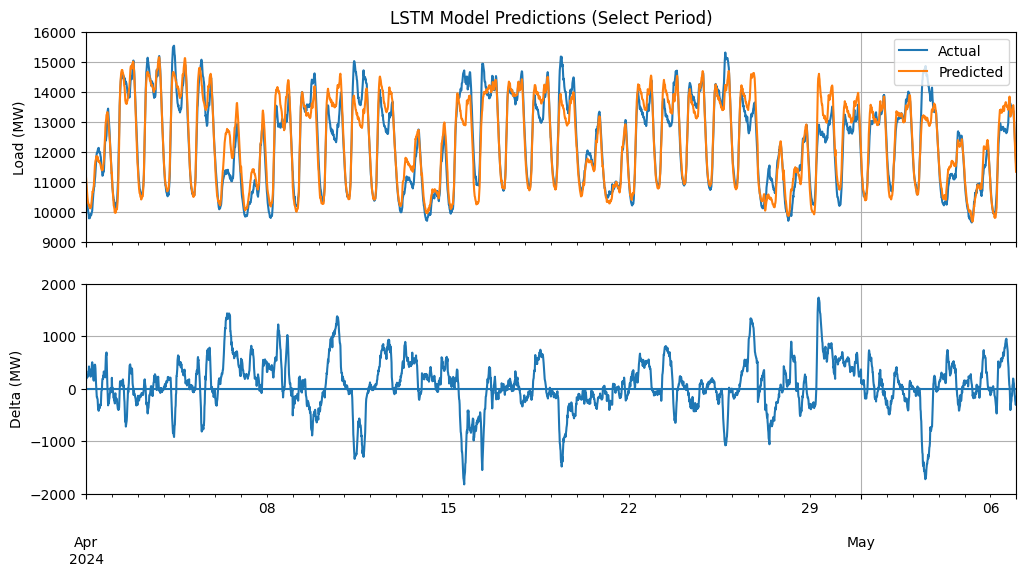

In [17]:
# Plot results (selected month, starting on a Monday)
lstm_valid_pred = invert_pred(y_valid_true, lstm.predict(valid_ds))

plot_results(y_valid_true.loc['2024-04-01':'2024-05-06'],
             lstm_valid_pred.loc['2024-04-01':'2024-05-06'],
             title='LSTM Model Predictions (Select Period)')

In [18]:
lstm_train_pred = invert_pred(y_train_true, lstm.predict(train_ds_pred))
lstm_resid = pd.DataFrame(y_train_true - lstm_train_pred, columns=['Residual'])

8703/8703 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step


In [19]:
resid_time = lstm_resid.copy()
resid_time['Time'] = resid_time.index.time
resid_time_by_day = resid_time.groupby('Time')['Residual'].mean()

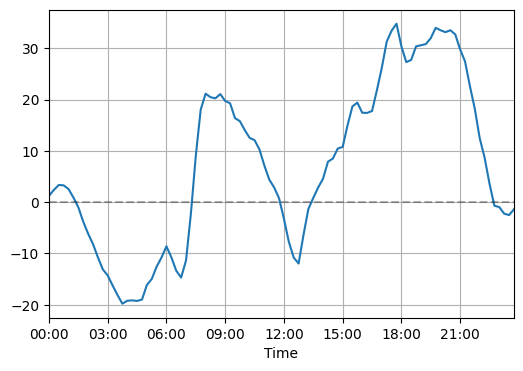

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
resid_time_by_day.plot(ax=ax)
ax.set_xlim('00:00:00','23:45:00')
ax.set_xticks(resid_time_by_day.index[::12])
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.grid();

Unlike the `LinearRegression` model, the residuals do not follow the daily electricity demand pattern. The mean residuals are most pronounced during the first hours of the day, after which the model underpredicts for the remainder of the day, and overpredicts towards the end of the day. We will fit a polynomial to the mean daily electricity demand to see if we can improve model performance.

In [21]:
data_time = data_train_transformed.copy()
data_time['Day'] = data_time.index.date
data_time['Time'] = data_time.index.time
data_time_pivot = data_time.pivot(index='Day', columns='Time', values='Load')

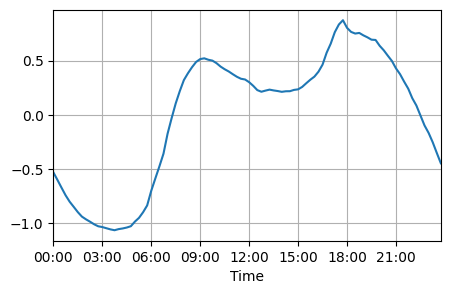

In [22]:
fig, ax = plt.subplots(figsize=(5, 3))
data_time_pivot.mean().plot(ax=ax)
ax.set_xlim('00:00:00','23:45:00')
ax.set_xticks(list(data_time_pivot.columns[:-1:12]))
ax.grid();

In [23]:
data_time_df = data_time_pivot.mean().to_frame()
data_time_df.columns = ['Load']
data_time_df.insert(loc=0, column='Time_X', value = (np.arange(96) / 96))

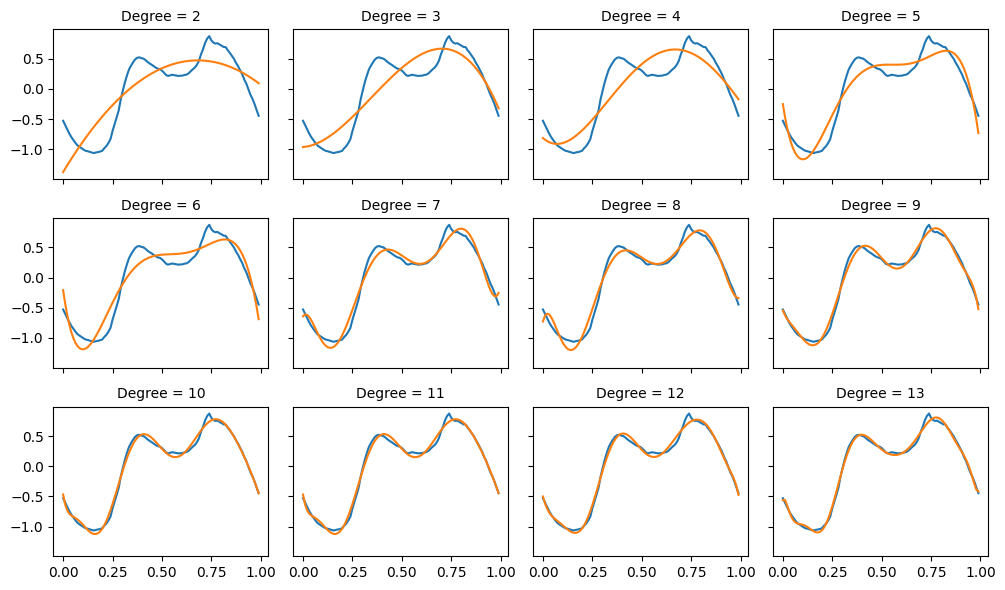

In [24]:
fig, ax = plt.subplots(3, 4, figsize=(10, 6), sharex=True, sharey=True)
axes = ax.ravel()

for i in range(12):
    poly = PolynomialFeatures(degree=(i+2), include_bias=False)
    X_ = poly.fit_transform(data_time_df[['Time_X']])

    clf = LinearRegression()
    clf.fit(X_, data_time_df['Load'])

    predict = clf.predict(X_)

    data_time_df.plot(x='Time_X', y='Load', ax=axes[i])
    pd.Series(predict, index=data_time_df['Time_X']).plot(ax=axes[i])
    axes[i].legend().remove()
    axes[i].set_title(f'Degree = {(i+2)}', fontsize=10)
    axes[i].set_xlabel(None)

plt.tight_layout()

The 9 degree polynomial appears to fit well.

In [25]:
def add_time_poly(df):
    """
    Adds Polynomial Features for time of day to a DataFrame.
    """
    df = df.merge(
    pd.DataFrame(np.vstack([X_] * int(len(df) / 96)),
                       columns=[f'Degree_{i+1}' for i in range(13)],
                       index=df.index),
    left_index=True, right_index=True
    )

    return df

In [26]:
# Prepare model data
X_train_boosted = add_lagging_data(data_train_transformed, lag_weeks=3)
X_train_boosted = add_weekday_holiday(X_train_boosted, public_holidays)
X_train_boosted = add_time_poly(X_train_boosted)
X_train_boosted.drop('Load', axis=1, inplace=True)

X_valid_boosted = add_lagging_data(data_valid_transformed, lag_weeks=3)
X_valid_boosted = add_weekday_holiday(X_valid_boosted, public_holidays)
X_valid_boosted = add_time_poly(X_valid_boosted)
X_valid_boosted.drop('Load', axis=1, inplace=True)

In [27]:
xgb = XGBRegressor()
xgb.fit(X_train_boosted, lstm_resid['Residual']);

In [28]:
lstm_train_pred_boosted = lstm_train_pred + xgb.predict(X_train_boosted)
lstm_valid_pred_boosted = lstm_valid_pred + xgb.predict(X_valid_boosted)

In [29]:
print(f'Training MAE: {mean_absolute_error(y_train_true, lstm_train_pred_boosted):.2f}')
print(f'Validation MAE: {mean_absolute_error(y_valid_true, lstm_valid_pred_boosted):.2f}')

Training MAE: 243.87
Validation MAE: 325.38


The hybrid model learns the training data very well, but does not yield any improvement in Validation MAE. This is likely overfitting the training data. We will therefore not use the hybrid model in our final assessment.

## 4. Final Results

In [30]:
data_test = pd.concat([
    data_valid.loc['2024-12-11':],
    data_2025.loc['2025-01-01':],
])

data_test_transformed = pd.DataFrame(std_load.transform(data_test),
                                          columns=data_test.columns,
                                          index=data_test.index)

y_test_true = data_2025['Load']

In [31]:
# Prep test data
X_test = add_weekday_holiday(data_test_transformed, public_holidays)
X_test['Holiday_next_day'] = X_test['Holiday'].shift(-96) # 1 day = 96 time intervals
X_test.drop('Holiday', axis=1, inplace=True)

In [32]:
# Prep test dataset
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_test.to_numpy(),
    targets=X_test['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96,
    batch_size=32)

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE: 398.74


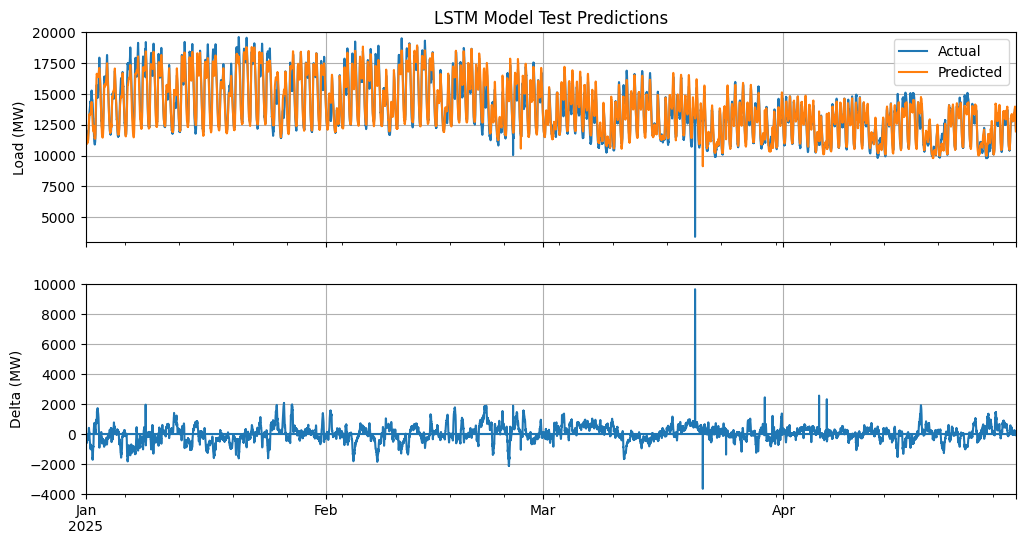

In [33]:
lstm_test_pred = invert_pred(y_test_true, lstm.predict(test_ds))
lstm_mae_test = mae(y_test_true, lstm_test_pred, invert=False)

plot_results(y_test_true,
             lstm_test_pred,
             title='LSTM Model Test Predictions')

MAE: 310.87


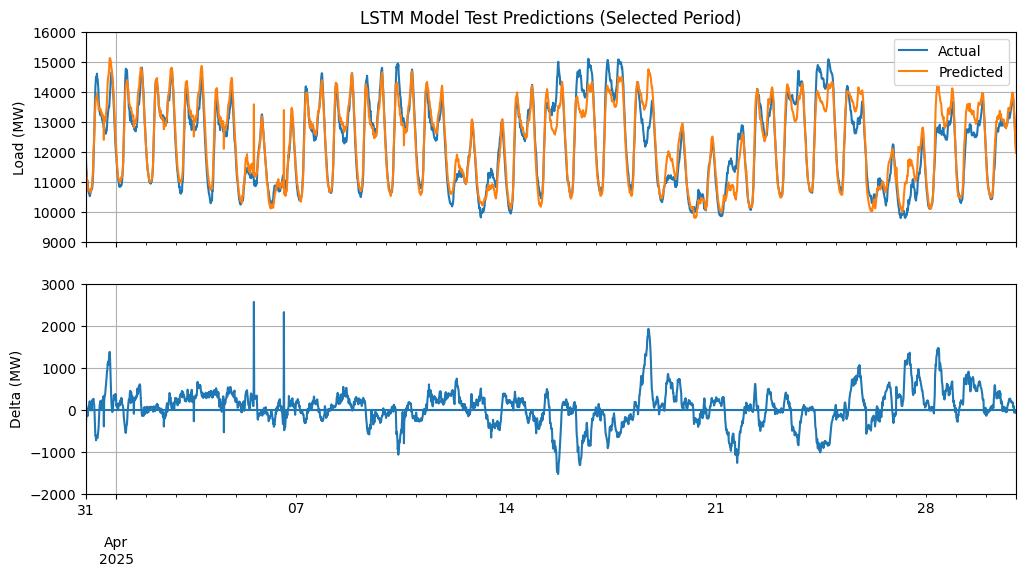

In [46]:
plot_results(y_test_true.loc['2025-03-31':],
             lstm_test_pred.loc['2025-03-31':],
             title='LSTM Model Test Predictions (Selected Period)')

plt.savefig('lstm-predictions.png', dpi=200, bbox_inches='tight');

In [47]:
simple_rnn_mae_test = mae(y_test_true, simple_rnn.predict(test_ds))
deep_rnn_mae_test = mae(y_test_true, deep_rnn.predict(test_ds))
gru_mae_test = mae(y_test_true, gru.predict(test_ds))

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [48]:
summary_df = pd.DataFrame({
    'Training MAE': [simple_rnn_mae_train, deep_rnn_mae_train, lstm_mae_train, gru_mae_train],
    'Validation MAE': [simple_rnn_mae_valid, deep_rnn_mae_valid, lstm_mae_valid, gru_mae_valid],
    'Test MAE': [simple_rnn_mae_test, deep_rnn_mae_test, lstm_mae_test, gru_mae_test]
}, index=['Simple RNN', 'Deep RNN', 'LSTM', 'GRU'])

for model in summary_df.index:
    summary_df.loc[f'{model} (%)'] = (summary_df.loc[model] / 
                                     (y_train_true.mean(), y_valid_true.mean(), y_test_true.mean()) * 100)

summary_df = summary_df.round(2)
summary_df

,Training MAE,Validation MAE,Test MAE
Simple RNN,349.13,332.04,427.81
Deep RNN,345.20,334.86,423.03
LSTM,322.28,319.39,398.74
GRU,327.32,319.37,392.56
Simple RNN (%),2.78,2.56,3.11
Deep RNN (%),2.75,2.58,3.07
LSTM (%),2.57,2.46,2.90
GRU (%),2.61,2.46,2.85


Each of the RNN models performed well, with the LSTM and GRU models achieving the best performance.